In [25]:
!pip install mujoco

# Set up GPU rendering.
from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()


""

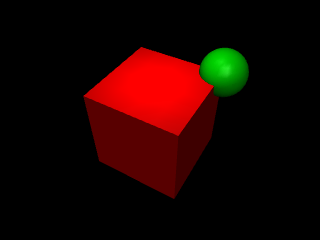

In [ ]:
#Initialize models in the worldbody
#<option gravity="0 0 10"/> #Inverse gravity
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

with mujoco.Renderer(model) as renderer:
    mujoco.mj_forward(model, data)
    renderer.update_scene(data)

    media.show_image(renderer.render())

In [ ]:
#Joint visualization
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

duration = 3.8  # (seconds)
framerate = 60  # (Hz)

#Simulate frames
frames = []
mujoco.mj_resetData(model, data)
with mujoco.Renderer(model) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data, scene_option=scene_option)
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate)

""

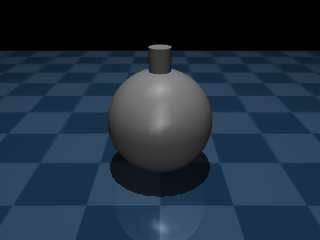

In [42]:
tippe_top = """
<mujoco model="tippe_top">
    <option integrator="RK4"/>

    <asset>
        <texture name="grid" type="2d" builtin="checker" rgb1="0.1 0.2 0.3" rgb2="0.2 0.3 0.4" width="300" height="300"/>
        <material name="grid" texture="grid" texrepeat="8 8" reflectance="0.2"/>
    </asset>

    <worldbody>
        <geom size="0.2 0.2 0.01" type="plane" material="grid"/>
        <light pos="0 0 0.6"/>
        <camera name="closeup" pos="0 -0.1 0.07" xyaxes="1 0 0 0 1 2"/>
        <body name="top" pos="0 0 0.02">
            <freejoint/>
            <geom name="ball" size="0.02"/>
            <geom name="stem" type="cylinder" pos="0 0 0.02" size="0.004 0.008"/>
            <geom name="ballast" type="box" size="0.023 0.023 0.005" pos="0 0 -0.015"
                contype="0" conaffinity="0" group="3"/>
        </body>
    </worldbody>

    <keyframe>
        <key name="spinning" qpos="0 0 0.02 1 0 0 0" qvel="0 0 0 0 1 200"/>
    </keyframe>
</mujoco>
"""

model = mujoco.MjModel.from_xml_string(tippe_top)
data = mujoco.MjData(model)
mujoco.mj_forward(model, data)

with mujoco.Renderer(model) as renderer:
    renderer.update_scene(data, camera="closeup")

    media.show_image(renderer.render())


In [43]:
duration = 7.0 #Seconds
framerate = 60 #Hz

frames = []
mujoco.mj_resetDataKeyframe(model, data, 0) #Resets to the first keyframe
with mujoco.Renderer(model) as renderer:
    while data.time < duration:
        mujoco.mj_step(model, data)
        if len(frames) < data.time * framerate:
            renderer.update_scene(data, camera="closeup")
            pixels = renderer.render()
            frames.append(pixels)

media.show_video(frames, fps=framerate)